In [1]:
import fastai.data.all as fai_data
import fastai.vision.all as fai_vision
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
path = fai_data.untar_data(fai_data.URLs.MNIST)
path

Path('/home/daynil/.fastai/data/mnist_png')

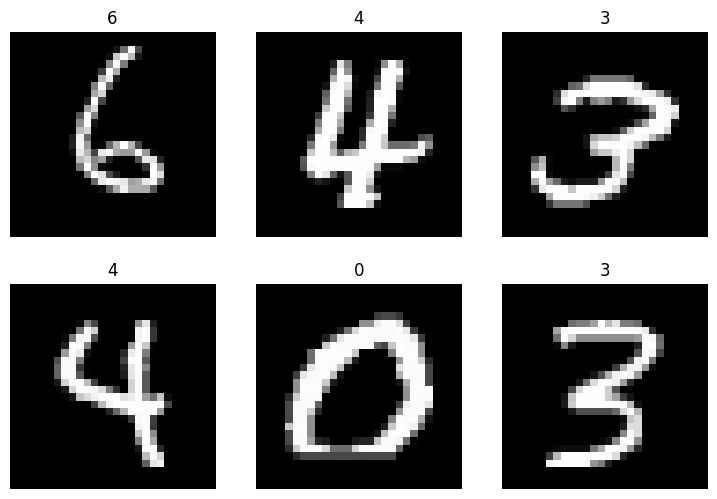

In [4]:
dls = fai_vision.DataBlock(
    blocks=(fai_vision.ImageBlock, fai_vision.CategoryBlock),
    get_items=fai_vision.get_image_files,
    splitter=fai_vision.GrandparentSplitter('training', 'testing'),
    get_y=fai_vision.parent_label
).dataloaders(path)
dls.show_batch(max_n=6)

## Common Code

In [5]:
# Pixels per dimension
px_per_dim = 28
torch.random.manual_seed(42)

def to_torch_tensor(xb: torch.Tensor, yb):
    return torch.tensor(xb, device=device), torch.tensor(yb, device=device)

def to_bw_flattened(xb):
    return (transforms.functional
                    .rgb_to_grayscale(xb).squeeze().view(
                        xb.shape[0], px_per_dim**2)
                )

def to_bw_flattened_torch_tensor(batch):
    xb, yb = batch
    xb = torch.tensor(xb, device=device)
    xb = to_bw_flattened(xb)
    yb = torch.tensor(yb, device=device)
    return xb, yb


def accuracy(preds, yb):
    accuracy_tns = (preds.argmax(dim=1) == yb).float()
    return (accuracy_tns.sum() / len(accuracy_tns)).item()

loss_fn = torch.nn.CrossEntropyLoss()

# This is just to allow me to use to_bw_flattened within a pytorch model
# Can ignore, conceptually
class GrayFlatLayer(torch.nn.Module):
    def __init__(self, lambd):
        super().__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

## Pure Python

In [6]:
hidden_neurons = 100
mnist_classes = 10

epochs = 15
lr = 0.001

w1 = torch.randn((px_per_dim**2, hidden_neurons), requires_grad=True, device=device)
b1 = torch.randn(hidden_neurons, requires_grad=True, device=device)

w2 = torch.randn((hidden_neurons, mnist_classes), requires_grad=True, device=device)
b2 = torch.randn(mnist_classes, requires_grad=True, device=device)

def simple_net(image_batch):
    res = image_batch@w1 + b1
    res = torch.nn.ReLU()(res)
    res = res@w2 + b2
    return res

def optimize():
    params = [w1, b1, w2, b2]
    for param in params:
        param.data -= param.grad.data * lr
        param.grad.zero_()
    

def train_step(xb, yb):
    preds = simple_net(xb)
    loss = loss_fn(preds, yb)
    acc = accuracy(preds, yb)

    loss.backward()
    optimize()
    return loss, acc

def valid_step(xb, yb):
    with torch.inference_mode():
        preds = simple_net(xb)
        loss = loss_fn(preds, yb)
        acc = accuracy(preds, yb)
        return loss, acc

for epoch in range(epochs):
    for batch in dls.train:
        xb, yb = to_bw_flattened_torch_tensor(batch)
        loss, acc = train_step(xb, yb)
    
    tot_loss, tot_acc = 0, 0
    for batch in dls.valid:
        xb, yb = to_bw_flattened_torch_tensor(batch)
        loss, acc = valid_step(xb, yb)
        tot_loss += loss
        tot_acc += acc

    valid_batches = len(dls.valid)
    print(f"Avg loss: {tot_loss / valid_batches}, Avg acc: {tot_acc / valid_batches}")

/tmp/ipykernel_13135/250536970.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb = torch.tensor(xb, device=device)
/tmp/ipykernel_13135/250536970.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yb = torch.tensor(yb, device=device)


Avg loss: 19.50469207763672, Avg acc: 0.4068471337579618
Avg loss: 11.47065544128418, Avg acc: 0.5615047770700637
Avg loss: 8.574058532714844, Avg acc: 0.6432125796178344
Avg loss: 7.100707530975342, Avg acc: 0.6889928343949044
Avg loss: 6.165310859680176, Avg acc: 0.7165605095541401
Avg loss: 5.505612850189209, Avg acc: 0.7348726114649682
Avg loss: 5.019713878631592, Avg acc: 0.7505971337579618
Avg loss: 4.634152889251709, Avg acc: 0.7621417197452229
Avg loss: 4.319098472595215, Avg acc: 0.7710987261146497
Avg loss: 4.067386150360107, Avg acc: 0.7814490445859873
Avg loss: 3.8423712253570557, Avg acc: 0.7870222929936306
Avg loss: 3.6473357677459717, Avg acc: 0.7938893312101911
Avg loss: 3.4826388359069824, Avg acc: 0.7984673566878981
Avg loss: 3.3330941200256348, Avg acc: 0.8036425159235668
Avg loss: 3.203057289123535, Avg acc: 0.8066281847133758


## Pytorch

In [18]:
hidden_neurons = 100
mnist_classes = 10

epochs = 15
lr = 0.001

model = torch.nn.Sequential(
    torch.nn.Linear(px_per_dim**2, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, mnist_classes)
).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

def train_step(xb, yb):
    preds = model(xb)
    loss = loss_fn(preds, yb)
    acc = accuracy(preds, yb)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss, acc

def valid_step(xb, yb):
    preds = model(xb)
    loss = loss_fn(preds, yb)
    acc = accuracy(preds, yb)
    return loss, acc

for epoch in range(epochs):
    model.train()
    for batch in dls.train:
        xb, yb = to_bw_flattened_torch_tensor(batch)
        loss, acc = train_step(xb, yb)
    
    tot_loss, tot_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch in dls.valid:
            xb, yb = to_bw_flattened_torch_tensor(batch)
            loss, acc = valid_step(xb, yb)
            tot_loss += loss
            tot_acc += acc
    
    valid_batches = len(dls.valid)
    print(f"Avg loss: {tot_loss / valid_batches}, Avg acc: {tot_acc / valid_batches}")

/tmp/ipykernel_6710/250536970.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb = torch.tensor(xb, device=device)
/tmp/ipykernel_6710/250536970.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yb = torch.tensor(yb, device=device)


Avg loss: 2.1178712844848633, Avg acc: 0.5622014331210191
Avg loss: 1.8576154708862305, Avg acc: 0.7061106687898089
Avg loss: 1.5482885837554932, Avg acc: 0.7451234076433121
Avg loss: 1.2592202425003052, Avg acc: 0.777468152866242
Avg loss: 1.0387413501739502, Avg acc: 0.8054339171974523
Avg loss: 0.8840926289558411, Avg acc: 0.8267316878980892
Avg loss: 0.7757946848869324, Avg acc: 0.8397691082802548
Avg loss: 0.69716876745224, Avg acc: 0.8515127388535032
Avg loss: 0.6381869316101074, Avg acc: 0.85828025477707
Avg loss: 0.5925345420837402, Avg acc: 0.8659434713375797
Avg loss: 0.5561208128929138, Avg acc: 0.8709195859872612
Avg loss: 0.526505172252655, Avg acc: 0.8750995222929936
Avg loss: 0.5020864009857178, Avg acc: 0.8788813694267515
Avg loss: 0.481544554233551, Avg acc: 0.8816679936305732
Avg loss: 0.46423453092575073, Avg acc: 0.8828622611464968


## Fastai

In [11]:
hidden_neurons = 100
mnist_classes = 10

epochs = 15
lr = 0.001

model = torch.nn.Sequential(
    GrayFlatLayer(transforms.Lambda(to_bw_flattened)),
    torch.nn.Linear(px_per_dim**2, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, mnist_classes)
).to(device)

learner = fai_vision.Learner(
    dls, model, lr=lr, loss_func=loss_fn, opt_func=fai_vision.SGD, metrics=fai_vision.accuracy
)

learner.fit(epochs, lr)

epoch,train_loss,valid_loss,accuracy,time
0,2.133905,2.118620,0.565000,00:09
1,1.877540,1.858544,0.707300,00:07
2,1.573797,1.549371,0.742100,00:06
3,1.288586,1.260185,0.775000,00:06
4,1.062684,1.039521,0.805000,00:06
5,0.919067,0.884853,0.824100,00:06
6,0.796627,0.776330,0.838800,00:06
7,0.741176,0.697940,0.849700,00:06
8,0.677359,0.638789,0.858600,00:06
9,0.619108,0.593043,0.865600,00:06


## Fastai Transfer Learning

In [7]:
epochs = 5

learner = fai_vision.vision_learner(
    dls, fai_vision.resnet18, metrics=accuracy
)

learner.fine_tune(epochs)

epoch,train_loss,valid_loss,accuracy,time
0,0.701943,0.463513,0.850000,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.134884,0.072383,0.977700,00:17
1,0.073699,0.055283,0.982400,00:17
2,0.046851,0.035289,0.989400,00:18
3,0.028342,0.026685,0.991500,00:18
4,0.013671,0.026875,0.992200,00:18
